# Name Entity Recognition(NER) using BERT:

![Image](https://confusedcoders.com/wp-content/uploads/2019/11/image2.png)


Name Entity Recognition in short called NER is method of information extractions from the text data which comes under the NLP space. The most common entities that are extracted from the text data could be name of the person, Country, company, contact information like email-id, phone-no, home address etc.

However NER tasks are not just limited to these standard entities, they could also be finetuned/trained to identify custom entities as per our need from the text data. 

There are function in <B>NLTK</B> and <B>Spacy</B> that can be used for NER tasks. However in this tutorial we will be going through how can we identify the entities of our interest using <B>BERT</B> by using the method <B>BertForTokenClassification</B> from HuggingFace Transformer package using Pytorch

There are extensive tutorials available online to understand BERT. However you can check out Jay Alammar's blog on [A Visual Guide to Using BERT for the First Time](https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/) which is one of the excellent way to learn BERT visually

# Why is it called Token Classification in Bert?
We know that in tasks like sequence classification, the entire sequence is classified to belong to 1 or 0 for binary classificationn and any 1 of the N classes for multiclass classfication. 

However in Token Classification every single token(i.e words) in the sequence is classified as 1 of the N classes. 

What do I mean by that? Assuming if it's a binary classification problem. If there is a sentence of 10 words, then each word is classified as 0 or 1, so the ouput dimension will be 10 * 2 with 2 being the probability of 0 and 1.

If it is a multiclass problem then the number of possible classes will be N and there will be N class probablilites for each token.

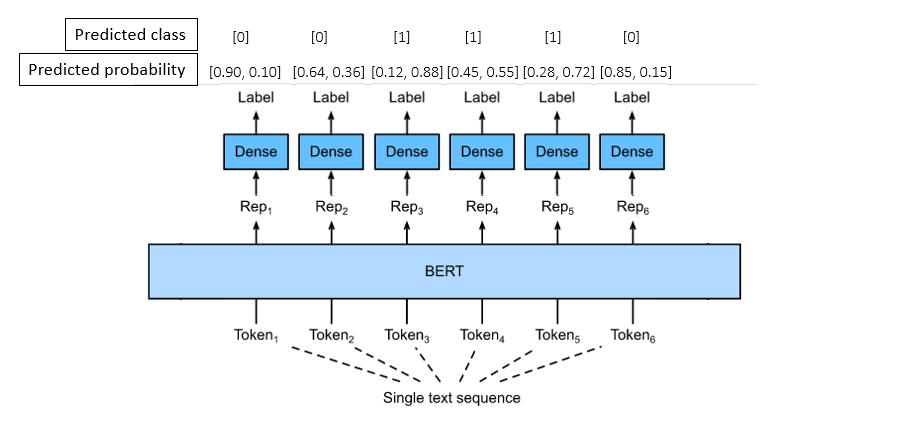

# About the data.
The data that we are going to be using for this tutorial is from the recently concluded 
[Coleridge Initiative - Show US the Data](https://www.kaggle.com/c/coleridgeinitiative-show-us-the-data) competition. The summary of the competition is to find the excerpt from the publication which represents the name of a dataset used for that particular analysis.

The textual information are from different publications, and each of them are stored as a json file with ids as unique key to identify them. The labels from publications are stored in the train.csv which we will use to label the textual documents from the publication. I would recommend you to go through the competition overview to understand in details about the data.

# Contents
* Declare configurations
* Reading the train dataset and preprocessing the text files
* Tokenization and Data Labelling for the NER task
* Define the DataLoader to batch the train dataset for training
* Model training using BertForTokenClassification
* Evaluation function to evaluate the model while training
* Reading the test dataset
* Prediction function to get the prediction for the test data
* Result consolidation

#### I have written a similar notebook on how we can use Roberta for NER tasks. Do check this [notebook](https://www.kaggle.com/thanish/roberta-token-classification-training-inference) for the tutorial. Consider leaving an upvote if you like and comment for any questions :)


In [ ]:
import os
import pandas as pd
import numpy as np
import json
import re
from nltk.tokenize import sent_tokenize 
from transformers import BertTokenizer, AutoTokenizer
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import transformers
from tqdm import tqdm
import glob
from sklearn.model_selection import train_test_split
import datetime 
import warnings
warnings.filterwarnings('ignore')

# Config

In [ ]:
platform = 'Kaggle'
model_name = 'model1_bert_base_uncased.bin'

if platform == 'Kaggle':
    bert_path = '../input/huggingface-bert/bert-base-uncased/'
    train_path = '/kaggle/input/coleridgeinitiative-show-us-the-data/train/'
    test_path = '/kaggle/input/coleridgeinitiative-show-us-the-data/test/*'
    model_path = '../input/coleridgemodels/'+ model_name
    
config = {'MAX_LEN':128,
          'tokenizer': AutoTokenizer.from_pretrained(bert_path , do_lower_case=True),
          'batch_size':5,
          'Epoch': 1,
          'train_path':train_path,
          'test_path':test_path, 
          'device': 'cuda' if torch.cuda.is_available() else 'cpu',
          'model_path':model_path,
          'model_name':model_name
         }

# Read the train data and combine the labels together

In [ ]:
train = pd.read_csv("../input/coleridgeinitiative-show-us-the-data/train.csv")

train_df = train.groupby(['Id']).agg(label_count = ('cleaned_label', 'count'),
                                     label = ('cleaned_label', '|'.join)).reset_index()
train_df

# Reading all the json train files

In [ ]:
def read_all_json(df, path):
    '''
    This function reads all the json input files and 
    return a dictionary containing the id as the key and all the 
    contents of the json as values
    '''
    text_data = {}
    for i, rec_id in tqdm(enumerate(df.Id), total = len(df.Id)):
        location = f'{path}{rec_id}.json'

        with open(location, 'r') as f:
            text_data[rec_id] = json.load(f)
        
    print("All files read")
    
    return text_data

In [ ]:
train_data_dict = read_all_json(df=train_df, path=config['train_path'])

# Data cleaning and Joining functions

In [ ]:
def clean_text(txt):
    '''
    This is text cleaning function
    '''
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower())

def data_joining(data_dict_id):
    '''
    This function is to join all the text data from different 
    sections in the json to a single text file. 
    '''
    data_length = len(data_dict_id)

    #     temp = [clean_text(data_dict_id[i]['text']) for i in range(data_length)]
    temp = [data_dict_id[i]['text'] for i in range(data_length)]
    temp = '. '.join(temp)
    
    return temp

def make_shorter_sentence(sentence):
    '''
    This function is to split the long sentences into chunks of shorter sentences upto the 
    maximum length of words specified in config['MAX_LEN']
    '''
    sent_tokenized = sent_tokenize(sentence)
    
    max_length = config['MAX_LEN']
    overlap = 20
    
    final_sentences = []
    
    for tokenized_sent in sent_tokenized:
        sent_tokenized_clean = clean_text(tokenized_sent)
        sent_tokenized_clean = sent_tokenized_clean.replace('.','').rstrip() 
        
        tok_sent = sent_tokenized_clean.split(" ")
        
        if len(tok_sent)<max_length:
            final_sentences.append(sent_tokenized_clean)
        else :
#             print("Making shorter sentences")
            start = 0
            end = len(tok_sent)
            
            for i in range(start, end, max_length-overlap):
                temp = tok_sent[i: (i + max_length)]
                final_sentences.append(" ".join(i for i in temp))

    return final_sentences

# Tokenization and Labeling the data

### Bert tokenization:
Before we move into labelling, let's understand how Bert tokenizer works. Tokenization is nothing but splitting the sentence into words, however Bert tokenizer splits sentences into words that are in the vocabulary. If there are compound words or words that are not part of the vocabulary then Bert splits them into multiple sub-words with each subword except the first subword starting with <B>"##"</B>. 

Check out this [blog](https://blog.floydhub.com/tokenization-nlp/) on different methods of tokenizer to understand why BERT tokenizes the sentence the way it does

### Labelling

The function form_labels() is actually where we label the data to be fed to the algorithms later in the notebook. 

Note: The label will be an excerpt from the train text.

<B>Example sentence</B>:
"control samples were selected from individuals who had participated in genomewide association studies performed by our group 787 samples from the neurogenetics collection at the coriell cell repository and 728 from the baltimore longitudinal study of aging blsa"



<B>Label</B>:
"genomewide association studies", "baltimore longitudinal study of aging".
As you could see there are two labels of interest to us from the example sentence.

<B>Portion to label</B>:
"control samples were selected from individuals who had participated in <B>genomewide association studies</B> performed by our group 787 samples from the neurogenetics collection at the coriell cell repository and 728 from the <B>baltimore longitudinal study of aging</B> blsa"

### How do we do this?
* Tokenize the train sentence.
<br>['control', 'samples', 'were', 'selected', 'from', 'individuals', 'who', 'had', 'participated', 'in', 'genome', '##wide', 'association', 'studies', 'performed', 'by', 'our', 'group', '78', '##7', 'samples', 'from', 'the', 'ne', '##uro', '##gen', '##etic', '##s', 'collection', 'at', 'the', 'co', '##rie', '##ll', 'cell', 'repository', 'and', '72', '##8', 'from', 'the', 'baltimore', 'longitudinal', 'study', 'of', 'aging', 'b', '##ls', '##a']

* Tokenize the labels
<br>[['genome', '##wide', 'association', 'studies'], ['baltimore', 'longitudinal', 'study', 'of', 'aging']]

* For each tokenized label, loop the tokenized train sentence and wherever you find a match label them as <B>'B'</B> and rest of them as <B>'O'</B>.

    Since there are two labels we will loop the train sentence twice

    At the end of the 1st loop for ['genome', '##wide', 'association', 'studies'], the label looks like this

    ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'B', 'B', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

    At the end of the 2nd loops for ['baltimore', 'longitudinal', 'study', 'of', 'aging'] the final label looks like this

    ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'B', 'B', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'B', 'B', 'B', 'B', 'O', 'O', 'O']

Most tutorials follow a pattern of <B>BIO</B> labelling (B-begin, I-interior, O-outside) which is nothing but label the first word as <B>B</B>, last word as <B>O</B> and all the intermediate words as <B>I</B> and all others as some other character say <B>X</B>

If labelled in this format then our labels would look like

['X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'B', 'I', 'I', 'O', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'B', 'I', 'I', 'I', 'O', 'X', 'X', 'X']

However I would like to stick to only labeling them as 'B' as I find it to be simple

In [ ]:
def form_labels(sentence, labels_list):
    '''
    This function labels the training data 
    '''
    matched_kwords = []
    matched_token = []
    un_matched_kwords = []
    label = []

    # Since there are many sentences which are more than 512 words,
    # Let's make the max length to be 128 words per sentence.
    tokens = make_shorter_sentence(sentence)
    
    for tok in tokens:    
        tok_split = config['tokenizer'].tokenize(tok)
        
        z = np.array(['O'] * len(tok_split)) # Create final label == len(tokens) of each sentence
        matched_keywords = 0 # Initially no kword matched    

        for kword in labels_list:
            if kword in tok: #This is to first check if the keyword is in the text and then go ahead
                kword_split = config['tokenizer'].tokenize(kword)
                for i in range(len(tok_split)):
                    if tok_split[i: (i + len(kword_split))] == kword_split:
                        matched_keywords += 1

                        if (len(kword_split) == 1):
                            z[i] = 'B'
                        else:
                            z[i] = 'B'
                            z[(i+1) : (i+ len(kword_split))]= 'B'

                        if matched_keywords >1:
                            label[-1] = (z.tolist())
                            matched_token[-1] = tok
                            matched_kwords[-1].append(kword)
                        else:
                            label.append(z.tolist())
                            matched_token.append(tok)
                            matched_kwords.append([kword])
                    else:
                        un_matched_kwords.append(kword)
                
    return matched_token, matched_kwords, label, un_matched_kwords

In [ ]:
def labelling(dataset, data_dict):
    '''
    This function is to iterate each of the training data and get it labelled 
    from the form_labels() function.
    '''
    
    Id_list_ = []
    sentences_ = []
    key_ = []
    labels_ = []
    un_mat = []
    un_matched_reviews = 0

    for i, Id in tqdm(enumerate(dataset.Id), total=len(dataset.Id)):

        sentence = data_joining(data_dict[Id])
        labels = train_df.label[train_df.Id == Id].tolist()[0].split("|")

        s, k, l, un_matched = form_labels(sentence=sentence, labels_list = labels)

        if len(s) == 0:
            un_matched_reviews += 1
            un_mat.append(un_matched)
        else: 
            sentences_.append(s)
            key_.append(k)
            labels_.append(l)
            Id_list_.append([Id]*len(l))

    print("Total unmatched keywords:", un_matched_reviews)
    sentences = [item for sublist in sentences_ for item in sublist]
    final_labels = [item for sublist in labels_ for item in sublist]
    keywords = [item for sublist in key_ for item in sublist]
    Id_list = [item for sublist in Id_list_ for item in sublist]
    
    return sentences, final_labels, keywords, Id_list


In [ ]:
train_sentences, train_labels, train_keywords, train_Id_list = labelling(dataset = train_df, 
                                                                         data_dict=train_data_dict)

print("")
print(f" train sentences: {len(train_sentences)}, train label: {len(train_labels)}, train keywords: {len(train_keywords)}, train_id list: {len(train_Id_list)}")

# Create DataFrame to remove the duplicates

In [ ]:
unique_df = pd.DataFrame({'id':train_Id_list, 
                          'train_sentences': train_sentences, 
                          'kword': train_keywords, 
                          'label':train_labels})
unique_df.label = unique_df.label.astype('str')
unique_df.kword = unique_df.kword.astype('str')
unique_df['sent_len'] = unique_df.train_sentences.apply(lambda x : len(x.split(" ")))
unique_df = unique_df.drop_duplicates()
print(unique_df.shape)
unique_df

# Taking a sample of the dataset
Let's take only a small sample of the data (0.05%) in this tutorial to train a model for experimentation. You can use the entire dataset or whatever sample size you want

In [ ]:
unique_df = unique_df.sample(int(unique_df.shape[0]*0.10)).reset_index(drop=True)
unique_df.shape

# Train and validation split

In [ ]:
np.random.seed(100)
train_df, valid_df = train_test_split(unique_df, test_size=0.2)

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

print(train_df.shape, valid_df.shape)

# Converting the DataFrame back to list

In [ ]:
print("Let's look at a simple example")
print("Train sentence:", unique_df.train_sentences[0])
print("Train label:", unique_df.kword[0])
print("Train label:", unique_df.label[0])

We have labelled all our train dataset and our labelled positions are denoted as <B>B</B>. However when we have to pass it to the model we will have to convert them into numerical representation.

We will convert them as follows: {<B>'O'</B>: 0 , <B>'B'</B>: 1, <B>'P'</B>: 2}

Here <B>P</B> means padding which is appended to our train and label when the total word count in the sentence is not equal to the mentioned <B>MAX_LEN</B> in config. We will add the padding in the class <B>form_input()</B>

In [ ]:
tags_2_idx = {'O': 0 , 'B': 1, 'P': 2} # 'P' means padding. 

def dataset_2_list(df):
    id_list = df.id.values.tolist()
    sentences_list = df.train_sentences.values.tolist()
    keywords_list = df.kword.apply(lambda x : eval(x)).values.tolist()
    
    labels_list = df.label.apply(lambda x : eval(x)).values.tolist()    
    labels_list = [list(map(tags_2_idx.get, lab)) for lab in labels_list]
    
    return id_list, sentences_list, keywords_list, labels_list

final_train_id_list, final_train_sentences, final_train_keywords, final_train_labels = dataset_2_list(df=train_df)
final_valid_id_list, final_valid_sentences, final_valid_keywords, final_valid_labels = dataset_2_list(df=valid_df)

# Forming the input and defining the dataloader

One added information to note is we have set the Max_length to be 128 words per sentence. 
However when we tokenize it, due to Bert's way of splitting non-vocab and compound words into multiple sub-words, the no.of tokens could be more than the no. of words. If the number of tokens is <128 then the extra positions are padded with <B>"P"</B>, However if they exceed the Max_Length we truncate them to 128 tokens at this portion of the code which is a common practice.

```
if len(toks)>self.max_length:
    toks = toks[:self.max_length]
    label = label[:self.max_length]
```

Do you feel there could be information loss due to the truncation? Well if you check <B>make_shorter_sentence(sentence)</B> function there is a variable <B>overlap=20</B>, So the begining of every sentence is from the last 20 words from the previous sentence. So the tokens truncated in the sentence1 could be captured in the sentence 2.

In [ ]:
class form_input():
    def __init__(self, ID, sentence, kword, label, data_type='test'):
        self.id = ID
        self.sentence = sentence
        self.kword = kword
        self.label = label
        self.max_length = config['MAX_LEN']
        self.tokenizer = config['tokenizer']
        self.data_type = data_type
    
    def __len__(self):
        return len(self.sentence)
    
    def __getitem__(self, item):
        toks = config['tokenizer'].tokenize(self.sentence[item])
        label = self.label[item]

        if len(toks)>self.max_length:
            toks = toks[:self.max_length]
            label = label[:self.max_length]
        
        
        ########################################
        # Forming the inputs
        ids = config['tokenizer'].convert_tokens_to_ids(toks)
        tok_type_id = [0] * len(ids)
        att_mask = [1] * len(ids)
        
        # Padding
        pad_len = self.max_length - len(ids)        
        ids = ids + [2] * pad_len
        tok_type_id = tok_type_id + [0] * pad_len
        att_mask = att_mask + [0] * pad_len
        
        ########################################            
        # Forming the label
        if self.data_type !='test':
            label = label + [2]*pad_len
        else:
            label = 1
            
        
        return {'ids': torch.tensor(ids, dtype = torch.long),
                'tok_type_id': torch.tensor(tok_type_id, dtype = torch.long),
                'att_mask': torch.tensor(att_mask, dtype = torch.long),
                'target': torch.tensor(label, dtype = torch.long)
               }
            

In [ ]:
train_prod_input = form_input(ID=final_train_id_list, 
                              sentence=final_train_sentences, 
                              kword=final_train_keywords, 
                              label=final_train_labels, 
                              data_type='train')

valid_prod_input = form_input(ID=final_valid_id_list, 
                              sentence=final_valid_sentences, 
                              kword=final_valid_keywords, 
                              label=final_valid_labels, 
                              data_type='valid')

train_prod_input_data_loader = DataLoader(train_prod_input, 
                                          batch_size= config['batch_size'], 
                                          shuffle=True)

valid_prod_input_data_loader = DataLoader(valid_prod_input, 
                                          batch_size= config['batch_size'], 
                                          shuffle=True)


In [ ]:
# Checking a sample input
ind = 1
print("Input sentence:")
print(final_train_sentences[ind])

print("")
print("Input label:")
print(final_train_keywords[ind])

print("")
print("Output:")
train_prod_input[ind]#, valid_prod_input[ind]

As we can see that the input sentence we passed to the function returned a dictionary of 
```ids, tok_type_ids, att_mask, target```.

The <B>ids</B> contains some numbers which is nothing but the index position of the tokens in the Bert vocabulary. 
If you want to know how the values are obtained in the <B>ids</B> I would recommend downloading the vocab.txt from [HuggingFace repo](https://huggingface.co/bert-base-uncased/tree/main) and checking the index with respect to the token starting from 0. 

I have shown the token ids for the first 5 words of an example sentence (<B>"2 comparsions with the most"</B>) in the screenshot below. The <B>2</B> in the ids are nothing but padded value.

The <B>att_mask</B> contains <B>1</B> for the all the tokens positions and <B>0</B> for all the padded positsion, so the model give attention to the tokens and not the padded positions.

<B>tok_type_id</B> is not required for this task so we can skip them.


<B>target</B> as we saw before are lablled as <B>1</B> for the label positions("survey of doctorate recipients"), <B>0</B> for the others and <B>2</B> for the padded positions. 

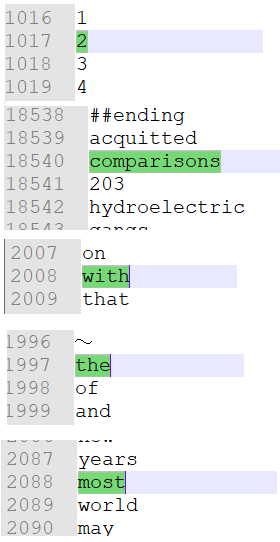

# Training section

In [ ]:
def train_fn(data_loader, model, optimizer):
    '''
    Functiont to train the model
    '''
    
    train_loss = 0
    for index, dataset in enumerate(tqdm(data_loader, total = len(data_loader))):
        batch_input_ids = dataset['ids'].to(config['device'], dtype = torch.long)
        batch_att_mask = dataset['att_mask'].to(config['device'], dtype = torch.long)
        batch_tok_type_id = dataset['tok_type_id'].to(config['device'], dtype = torch.long)
        batch_target = dataset['target'].to(config['device'], dtype = torch.long)
                
        output = model(batch_input_ids, 
                       token_type_ids=None,
                       attention_mask=batch_att_mask,
                       labels=batch_target)
        
        step_loss = output[0]
        prediction = output[1]
        
        step_loss.sum().backward()
        optimizer.step()        
        train_loss += step_loss
        optimizer.zero_grad()
        
    return train_loss.sum()

In [ ]:
def eval_fn(data_loader, model):
    '''
    Functiont to evaluate the model on each epoch. 
    We can also use Jaccard metric to see the performance on each epoch.
    '''
    
    model.eval()
    
    eval_loss = 0
    predictions = np.array([], dtype = np.int64).reshape(0, config['MAX_LEN'])
    true_labels = np.array([], dtype = np.int64).reshape(0, config['MAX_LEN'])
    
    with torch.no_grad():
        for index, dataset in enumerate(tqdm(data_loader, total = len(data_loader))):
            batch_input_ids = dataset['ids'].to(config['device'], dtype = torch.long)
            batch_att_mask = dataset['att_mask'].to(config['device'], dtype = torch.long)
            batch_tok_type_id = dataset['tok_type_id'].to(config['device'], dtype = torch.long)
            batch_target = dataset['target'].to(config['device'], dtype = torch.long)

            output = model(batch_input_ids, 
                           token_type_ids=None,
                           attention_mask=batch_att_mask,
                           labels=batch_target)

            step_loss = output[0]
            eval_prediction = output[1]

            eval_loss += step_loss
            
            eval_prediction = np.argmax(eval_prediction.detach().to('cpu').numpy(), axis = 2)
            actual = batch_target.to('cpu').numpy()
            
            predictions = np.concatenate((predictions, eval_prediction), axis = 0)
            true_labels = np.concatenate((true_labels, actual), axis = 0)
            
    return eval_loss.sum(), predictions, true_labels

# Model initialization and train

We have initialized the model in the function below as

```
model = transformers.BertForTokenClassification.from_pretrained('bert-base-uncased',  num_labels = len(tags_2_idx))
```

<U>Note</U>: 
Do you know why the label ```num_labels = len(tags_2_idx)```? because we have only 3 classes <B>[O, B, P]</B> so each of the token can be classified as any of the 3 i.e.
```tags_2_idx={'O':0 , 'B':1, 'P':2}```

However if we had labelled them in the <B>BIO</B> format then there would be 5 classes <B>[X, B, I, O, P]</B> then ```tags_2_idx={'X':0 , 'B':1, 'I':2, 'O':3, 'P':5}``` so num_labels would have been ```num_labels = 5```

In [ ]:
def train_engine(epoch, train_data, valid_data):
    model = transformers.BertForTokenClassification.from_pretrained('bert-base-uncased',  num_labels = len(tags_2_idx))
    model = nn.DataParallel(model)
    model = model.to(config['device'])
    
    params = model.parameters()
    optimizer = torch.optim.Adam(params, lr= 3e-5)
    
    best_eval_loss = 1000000
    for i in range(epoch):
        train_loss = train_fn(data_loader = train_data, 
                              model=model, 
                              optimizer=optimizer)
        eval_loss, eval_predictions, true_labels = eval_fn(data_loader = valid_data, 
                                                           model=model)
        
        print(f"Epoch {i} , Train loss: {train_loss}, Eval loss: {eval_loss}")

        if eval_loss < best_eval_loss:
            best_eval_loss = eval_loss           
            
            print("Saving the model")
            torch.save(model.state_dict(), config['model_name'])
            
    return model, eval_predictions, true_labels 

In [ ]:
model, val_predictions, val_true_labels = train_engine(epoch=config['Epoch'],
                                                       train_data=train_prod_input_data_loader, 
                                                       valid_data=valid_prod_input_data_loader)

# Reading the test data

In [ ]:
def read_test_json(test_data_folder):
    '''
    This function reads all the json input files and return a dictionary containing the id as the key
    and all the contents of the json as values
    '''

    test_text_data = {}
    total_files = len(glob.glob(test_data_folder))
    
    for i, test_json_loc in enumerate(glob.glob(test_data_folder)):
        filename = test_json_loc.split("/")[-1][:-5]

        with open(test_json_loc, 'r') as f:
            test_text_data[filename] = json.load(f)

        if (i%1000) == 0:
            print(f"Completed {i}/{total_files}")

    print("All files read")
    return test_text_data

In [ ]:
test_data_dict = read_test_json(test_data_folder=config['test_path'])

# Prediction function

For the prediction part we pass the text data sentence.

<U>Example test input:</U> 
```
"in section 5 the proposed method is illustrated by analyzing a diffusion tensor imaging dti data set from the alzheimer disease neuroimaging initiative adni database"
```
<U>Tokenize the input text</U>:
```
['in', 'section', '5', 'the', 'proposed', 'method', 'is', 'illustrated', 'by', 'analyzing', 'a', 'diffusion', 'tensor', 'imaging', 'dt', '##i', 'data', 'set', 'from', 'the', 'alzheimer', 'disease', 'ne', '##uro', '##ima', '##ging', 'initiative', 'ad', '##ni', 'database']
 ```
<U>Get the token ids</U>:
```
[1999, 2930, 1019, 1996, 3818, 4118, 2003, 7203, 2011, 20253, 1037, 19241, 23435, 12126, 26718, 2072, 2951, 2275, 2013, 1996, 21901, 4295, 11265, 10976, 9581, 4726, 6349, 4748, 3490, 7809]
```

<U>Prediction output</U>: 

The token Ids are passed to the trained model which outputs the predicted probabilites for each token and the argmax is taken to get the class with max probability and it looks like this.
```
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
```
<U>Final predicted keyword</U>:

Compare the prediction and the test input tokenized text. Get all the tokens that are predicted as <B>1</B> from the test input Tokenized text which is 

<B>[['tensor', 'imaging', 'dt', '##i', 'data', 'set'], ['alzheimer', 'disease', 'ne', '##uro', '##ima', '##ging', 'initiative', 'ad', '##ni', 'database']]</B>. 

Combine the subwords with <B>"##"</B>, Separate each element in the list by spaces and return them as the identified entity by the model 

<B>"tensor imaging dti data set", "alzheimer disease neuroimaging initiative adni database"</B>

<U>Note</U>: If you labelled your dataset in the <B>BIO</B> format then you will have to modify the <B>prediction_fn()</B> function accordingly

In [ ]:
# Prediction
def prediction_fn(tokenized_sub_sentence):

    tkns = tokenized_sub_sentence
    indexed_tokens = config['tokenizer'].convert_tokens_to_ids(tkns)
    segments_ids = [0] * len(indexed_tokens)

    tokens_tensor = torch.tensor([indexed_tokens]).to(config['device'])
    segments_tensors = torch.tensor([segments_ids]).to(config['device'])
    
    model.eval()
    with torch.no_grad():
        logit = model(tokens_tensor, 
                      token_type_ids=None,
                      attention_mask=segments_tensors)

        logit_new = logit[0].argmax(2).detach().cpu().numpy().tolist()
        prediction = logit_new[0]

        kword = ''
        kword_list = []

        for k, j in enumerate(prediction):
            if (len(prediction)>1):

                if (j!=0) & (k==0):
                    #if it's the first word in the first position
                    #print('At begin first word')
                    begin = tkns[k]
                    kword = begin

                elif (j!=0) & (k>=1) & (prediction[k-1]==0):
                    #begin word is in the middle of the sentence
                    begin = tkns[k]
                    previous = tkns[k-1]

                    if begin.startswith('##'):
                        kword = previous + begin[2:]
                    else:
                        kword = begin

                    if k == (len(prediction) - 1):
                        #print('begin and end word is the last word of the sentence')
                        kword_list.append(kword.rstrip().lstrip())

                elif (j!=0) & (k>=1) & (prediction[k-1]!=0):
                    # intermediate word of the same keyword
                    inter = tkns[k]

                    if inter.startswith('##'):
                        kword = kword + "" + inter[2:]
                    else:
                        kword = kword + " " + inter


                    if k == (len(prediction) - 1):
                        #print('begin and end')
                        kword_list.append(kword.rstrip().lstrip())

                elif (j==0) & (k>=1) & (prediction[k-1] !=0):
                    # End of a keywords but not end of sentence.
                    kword_list.append(kword.rstrip().lstrip())
                    kword = ''
                    inter = ''
            else:
                if (j!=0):
                    begin = tkns[k]
                    kword = begin
                    kword_list.append(kword.rstrip().lstrip())

    return kword_list

In [ ]:
def long_sent_split(long_tokens):
    '''
    If the token length is >the max length this function splits it into 
    mutiple list of specified smaller max_length
    '''
    
    start = 0
    end = len(long_tokens)
    max_length = 64

    final_long_tok_split = []
    for i in range(start, end, max_length):
        temp = long_tokens[i: (i + max_length)]
        final_long_tok_split.append(temp)
    return final_long_tok_split

In [ ]:
def get_predictions(data_dict):
    
    results = {}

    for i, Id in enumerate(data_dict.keys()):
        current_id_predictions = []
        
#         print(Id)
        sentences = data_joining(data_dict[Id])
        sentence_tokens = sent_tokenize(sentences)
        
        for sub_sentence in sentence_tokens:
            cleaned_sub_sentence = clean_text(sub_sentence)
        
            # Tokenize the sentence
            tokenized_sub_sentence = config['tokenizer'].tokenize(cleaned_sub_sentence)
            
            if len(tokenized_sub_sentence) == 0:
                # If the tokenized sentence are empty
                sub_sentence_prediction_kword_list = []
                
            elif len(tokenized_sub_sentence) <= 512:
                # If the tokenized sentence are less than 512
                sub_sentence_prediction_kword_list = prediction_fn(tokenized_sub_sentence)

            else:
                # If the tokenized sentence are >512 which is long sentences
                long_sent_kword_list = []
                
                tokenized_sub_sentence_tok_split = long_sent_split(tokenized_sub_sentence)
                for i, sent_tok in enumerate(tokenized_sub_sentence_tok_split):
                    if len(sent_tok) != 0:
                        kword_list = prediction_fn(sent_tok)
                        long_sent_kword_list.append(kword_list)
                flat_long_sent_kword = [item for sublist in long_sent_kword_list for item in sublist]
                sub_sentence_prediction_kword_list = flat_long_sent_kword
                            
            if len(sub_sentence_prediction_kword_list) !=0:
                current_id_predictions = current_id_predictions + sub_sentence_prediction_kword_list

        results[Id] = list(set(current_id_predictions))
                
    print("All predictions completed")
    
    return results

In [ ]:
results = get_predictions(data_dict = test_data_dict)

In [ ]:
sub_df = pd.DataFrame({'Id': list(results.keys()),
                       'PredictionString': list(results.values())})
sub_df.PredictionString = sub_df.PredictionString.apply(lambda x : "|".join(x))
sub_df

In [ ]:
sub_df.to_csv("submission.csv", index=False)

# --------- Do upvote if you like :) ---------